In [1]:
import crypten
import torch
import numpy as np
import matplotlib.pyplot as plt
from plots_helper import plot_error_by_iterations

import crypten.mpc as mpc
import crypten.communicator as comm 

crypten.init()

torch.set_num_threads(1)
torch.set_printoptions(precision=16) # default

## The Code

In [138]:
def sample_dataset(n, p, c, k):
    np.random.seed(0)
    x = np.random.uniform(-1, 1, (n, p))
    noise = np.random.uniform(-c, c, n)
    
    theta_star = np.random.uniform(-1, 1, p)

    # make theta_star k-sparse randomly
    index = np.random.choice(range(p), k)
    for i in index:
        theta_star[i] = 0
        
    y = x @ theta_star + noise
    return torch.tensor(x), torch.tensor(y), torch.tensor(theta_star)

In [61]:
# ISSUE: round not supported
def mod_2a(v, a):
    power_a = 2 ** a
    for i in range(len(v)):
        integer_part = v[i].div(power_a)
        integer_part = integer_part.int()
        v[i] = v[i] - power_a * integer_part

    return v

In [63]:
v = torch.tensor([10.55, 20.78, 30.13, 40.99])
mod_2a(v, 2)

tensor([2.5500001907348633, 0.7800006866455078, 2.1299991607666016,
        0.9900016784667969])

In [32]:
# ISSUE: round not supported
def cut_c_bits(v, c):
    power_c = 2 ** c
    for i in range(len(v)):
        v[i] = v[i].div(power_c)

    return v

In [228]:
# for truncation step
# select the smallest (n - k) values, and return their index

def get_min_indices_old(x, k):
    n = len(x)

    # special cases
    if k == 0:
        # special case, return only zero
        return crypten.cryptensor(torch.zeros(n), ptype=crypten.mpc.arithmetic)
    if k == n:
        return x # no change needed

    x_abs = x.abs()
    max_value = x_abs.max()
    k = n - k
    result_index = []

    for i in range(k):
        min_index = x_abs.argmin(one_hot=False)

        min_index_rev = min_index.get_plain_text()
        x_abs[min_index_rev] = max_value # set to the maximum value to avoid finding it in the next iteration

        result_index.append(min_index_rev)

    return result_index


In [229]:
# for truncation step
# make a vector v k-sparse, meaning that only the largest k values are non-zero
# select the smallest (n - k) values, and make them zero

def get_min_indices(x, k, bits_to_cut):
    x_copy = x.clone() # to avoid cutting bits on the real input, which is returned at the end

    n = len(x)
    if k == 0 or k == n:
        return x # no change needed
    
    # preparing for argmax:
    # cutting c bits for efficiency reasons
    if bits_to_cut > 0:
        x_copy = x_copy.div(bits_to_cut) # removing the last c=6 bits from every share

    x_copy_abs = x_copy.abs()
    max_value = x_copy_abs.max()
    argmin_index_rev = []
    k = n - k

    for _ in range(k):
        min_index = x_copy_abs.argmin(one_hot=False)

        min_index_rev = min_index.get_plain_text()
        x_copy_abs[min_index_rev] = max_value # set to the maximum value to avoid finding the same index in the next iteration

        argmin_index_rev.append(min_index_rev)

    return argmin_index_rev

In [231]:
@mpc.run_multiprocess(world_size=3)
def distributed_noise_and_round(nabla_input, theta_prev_input, n, p, k=2, a=64, c=2, eta=0.1):
    nabla = crypten.cryptensor(nabla_input, ptype=crypten.mpc.arithmetic)
    theta_prev = crypten.cryptensor(theta_prev_input, ptype=crypten.mpc.arithmetic)

    # TODO: add noise

    # Local computation: add gradients
    nabla_sum = 0
    for i in range(n):
        nabla_sum += nabla[i]

    # Local computaion: aggregate gradients
    nabla_prev = nabla_sum.div(n)

    # Local computaion: perform gradient descend
    theta_t = theta_prev - eta * nabla_prev

    # Ring 2^a ==> TODO when it works, move inside get_min_indices
    # theta_trunc = mod_2a(theta_trunc, a)

    min_indices = get_min_indices(theta_t, k, c)

    return min_indices, theta_t.get_plain_text() # this has size (n - k)
    


In [246]:
def iht_mpc(n, p, k, T_max, noise_param, a=64, c=0, eta=0.1, ebs=0.01):
    x_input, y_input, theta_star = sample_dataset(n, p, noise_param, k)
    theta_prev = torch.zeros(p)
    nabla = torch.zeros((n, p))
    nabla = nabla.double()
    theta_prev = theta_prev.double()

    # x_input = torch.tensor([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
    # theta_prev = torch.tensor([0, 0, 0])
    # y_input = torch.tensor([10, 20, 30])

    iteration_error = [0]
    for i in range(n):
        var1 = theta_prev.matmul(x_input[i]) # --> scalar
        var1 = var1 - y_input[i] # --> scalar
        var2 = x_input[i].transpose(0, -1)
        nabla[i] = var2.mul(var1)

    for t in range(T_max):
        result = distributed_noise_and_round(nabla, theta_prev, n, p, k, a, c, eta)
        min_indices, theta_t = result[0] # just from the first party

        if k > 0 and k < n:
            for i in min_indices:
                theta_t[i] = 0

        e = torch.norm(theta_t - theta_star, p=2)
        diff = abs(e - iteration_error[-1])

        iteration_error.append(e.item())
        theta_prev = theta_t

        if diff <= ebs:
            break

    return iteration_error[1:]


In [247]:
it_err = iht_mpc(n=100, p=5, k=3, T_max=50, noise_param=0.05, a=64, c=2, eta=0.1, ebs=0.01)
it_err

[0.7987809465531617,
 0.7778777795735085,
 0.757012657974426,
 0.7361166549093975,
 0.7152120063951242,
 0.6943600545536083,
 0.6734874157963688,
 0.6526402512604397,
 0.6318048094144578,
 0.6109963950301252,
 0.5901576010283233,
 0.5693754477676117,
 0.5485929616953671,
 0.5278344876981164,
 0.5071090427371916,
 0.48639897873622356,
 0.4657251711669628,
 0.4450756096337388,
 0.4244962035487525,
 0.40395364541060985,
 0.38346235857746036,
 0.3630124481337648,
 0.3426630294683163,
 0.32238422853698673,
 0.3022192795722005,
 0.28217397383373777,
 0.2622852437029328,
 0.2426049568933031,
 0.2231791561286094,
 0.2040296888247386,
 0.18530721558597826,
 0.16713297449961417,
 0.14974507324852748,
 0.1333764518250117,
 0.11848388955160581,
 0.10574138750302339,
 0.09591660739587153]

## Experiments

### Convergence by n

In [280]:
n_values = [1, 5, 10] # * 10^3
c_values = [0, 2, 5] # bits to cut
p = 64
k = 54 # just 10 features will be made zero

results = {}

for n in n_values:
    for c in c_values:
        it_err = iht_mpc(n=n * (10 ** 3), p=p, k=k, T_max=30, noise_param=0.05, a=64, c=c, eta=0.1, ebs=0.01)
        results[(n, c)] = it_err
        print(f'done with n={n}, c={c}')

done with n=1, c=0
done with n=1, c=2
done with n=1, c=5
done with n=5, c=0
done with n=5, c=2
done with n=5, c=5
done with n=10, c=0
done with n=10, c=2
done with n=10, c=5


In [293]:
def plot_error_by_iterations(results):
    _, axs = plt.subplots(2, 2, figsize=(14, 10))

    r, c = 0, 0
    values_2 = set([key[1] for key in results.keys()])

    for i in values_2:
        for key in results.keys():
            if key[1] == i:
                T = len(results[key])
                n, k = key

                axs[r, c].plot(range(T), results[key], label=f'n={n}k',
                         color=(np.random.random(), np.random.random(), np.random.random()))

        axs[r, c].set_title(f'p = {64}, k = {10}, c = {i}')
        axs[r, c].legend(loc=1)
        
        c += 1
        if c == 2:
            c = 0
            r += 1

    for ax in axs.flat:
        ax.set(xlabel='T (iterations)', ylabel='||theta_t - theta*||2')
        
    plt.show()

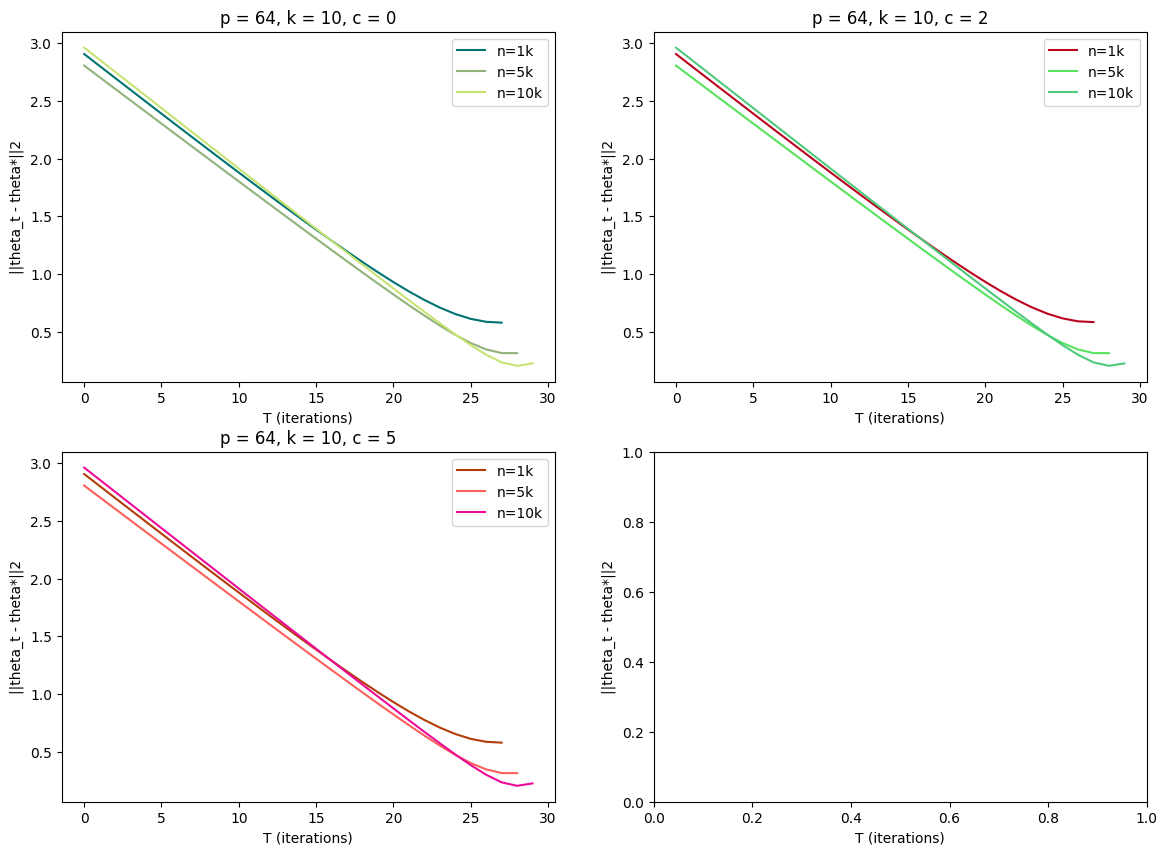

In [294]:
plot_error_by_iterations(results)

In [127]:
x = torch.tensor([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
theta_prev = torch.tensor([0, 0, 0])
res = distributed_noise_and_round(x, theta_prev, 3, 3, k=1, c=1)
res[0]

Source 0 x in the beginningr = tensor([-0.0499877929687500, -0.0999908447265625, -0.1499786376953125])
Source 0 x_abs before for = tensor([0.0499877929687500, 0.0999908447265625, 0.1499786376953125])
Source 0 x_abs at iteration 0 = tensor([0.1499786376953125, 0.0999908447265625, 0.1499786376953125])
Source 0 min_index at iteration 0 = 0
Source 0 x_abs at iteration 1 = tensor([0.1499786376953125, 0.1499786376953125, 0.1499786376953125])
Source 0 min_index at iteration 1 = 1


[tensor(0), tensor(1)]

In [64]:
x = np.random.uniform(-1, 1, (10, 5))
x = torch.tensor(x)
x

tensor([[ 1.0049010220553733e-01, -5.6513078335045019e-01,
         -2.3563755497946204e-04, -6.3371088822761612e-01,
         -7.9380945716205287e-01],
        [-7.6255672116499618e-01,  7.5319178389827712e-02,
         -9.6310187614123688e-01,  3.9289678058180844e-01,
         -4.0821254666947748e-01],
        [ 6.8646090501077617e-01, -9.4567624261446626e-01,
         -5.3974318516583897e-01, -6.9913221289797423e-01,
          5.6632171767704764e-01],
        [-4.9351873175459615e-01,  8.9401097872553414e-01,
         -5.3153226302694745e-01, -2.0807460689157531e-01,
         -3.4665039688941413e-03],
        [-7.9848715232202050e-02,  1.6745213479023358e-02,
          1.5330334092048226e-01, -4.0054958771647420e-01,
          1.6423073453578252e-01],
        [-3.7043540424461030e-01, -4.5364646663304864e-02,
          1.6832969457822644e-01,  4.4238532432767275e-01,
          9.6653456579762809e-01],
        [-1.9407374577397762e-01,  7.4912554188213143e-01,
          6.30016300049

In [60]:
for c in [1, 2, 3, 4, 5, 6]:
    count = 0
    for i in range(100):
        x = np.random.uniform(-1, 1, 10)
        x = torch.tensor(x)

        result = distributed_noise_and_round(x, 2, c)
        if result[0][0] != result[0][1]:
            count += 1

    print("c = {c}", count)

c = {c} 0
c = {c} 0
c = {c} 0
c = {c} 0
c = {c} 0
c = {c} 0
